<a href="https://colab.research.google.com/github/francoislegac/brain_tumor_classif/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain MRI Images for Brain Tumor Classification

This is an old project of image classification. The dataset is very small (only approx. 250 images). The tumors are easy to detect for a human-being so we should not expect to much difficulties for our model to detect the disease. 

The goal here is essentialy to manipulate Tensorflow and Keras libraries. 

## Project overview and objectives

Binary classification problem on Magnetic resonance imaging (MRI) scans: the patient has a tumor or not?

Evaluation metric: accuracy

## Quick dataset description

The dataset comes from the following kaggle competition
Source: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

Encoding (NO = 0, YES = 1)

No further info

Sizes: 
- Training set: 192 images
- Validation set: 51 images 
- Test set: 10 images

Split: 75% / 20% / 5%


## Description of a brain tumor

A brain tumor is a mass or growth of abnormal cells in your brain.

Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain (secondary, or metastatic, brain tumors).

How quickly a brain tumor grows can vary greatly. The growth rate as well as location of a brain tumor determines how it will affect the function of your nervous system.

![picture](https://drive.google.com/uc?export=view&id=1waQokBGvvEECn8JHFI-Ka_u0dFR_CT1F)   

*example of a brain tumor detection in the right cerebral hemisphere*

source: https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084

## Let's set up the environment

Splitting the data in train, val and test folders for easier use

Architecture: 


In [117]:
#useful libraries
import os
import shutil
import random 
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import imutils
import itertools #for the confusion matrix

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop 
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix


%matplotlib inline

In [3]:
from google.colab import drive 

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
os.chdir('drive/MyDrive/Colab Notebooks/dl_projects_2021/brain_tumor/')

In [ ]:
!mkdir TRAIN VAL TEST TRAIN/YES TRAIN/NO VAL/YES VAL/NO TEST/YES TEST/NO

In [5]:
# tree recursively print out the file structure for the current folder you are in
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (117 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [6]:
!tree -d

.
└── images
    ├── braintumor_ds
    │   ├── no
    │   └── yes
    ├── TEST
    │   ├── NO
    │   └── YES
    ├── TEST_PREP
    │   ├── NO
    │   └── YES
    ├── TRAIN
    │   ├── NO
    │   └── YES
    ├── TRAIN_PREP
    │   ├── NO
    │   └── YES
    ├── VAL
    │   ├── NO
    │   └── YES
    └── VAL_PREP
        ├── NO
        └── YES

22 directories


In [120]:
#splitting the images into train, val test
IMG_PATH = 'images/braintumor_ds'
a,b,c = 0,0,0
for CLASS in os.listdir(IMG_PATH): #CLASS = YES/NO
  if not CLASS.startswith('.'): #in case there are hidden files
    IMG_NUM = len(os.listdir(IMG_PATH + '/' + CLASS))
    LIST_FILES = os.listdir(IMG_PATH+'/'+CLASS) #files in YES then NO folders
    random.shuffle(LIST_FILES)
    for i, FILE_NAME in enumerate(LIST_FILES):
      img = IMG_PATH + '/' + CLASS + '/' + FILE_NAME 
      if i < 5:
        shutil.copy(img, 'images/TEST' + '/' + CLASS.upper() + '/' + FILE_NAME)
        a+= 1
      elif i < IMG_NUM*8//10:
        shutil.copy(img, 'images/TRAIN' + '/' + CLASS.upper() + '/' + FILE_NAME)
        b+=1
      else:
        shutil.copy(img, 'images/VAL' + '/' + CLASS.upper() + '/' + FILE_NAME)
        c+=1

In [159]:
print(f'TEST: {a} images, TRAIN: {b} images, VAL: {c} images')

TEST: 10 images, TRAIN: 192 images, VAL: 51 images


In [122]:
IMG_PATH = 'braintumor_ds'

TRAIN_PATH = IMG_PATH + '/' + 'TRAIN'
VAL_PATH = IMG_PATH + '/' + 'VAL'
TEST_PATH = IMG_PATH + '/' + 'TEST'

In [123]:
def load_images(path):
  X, y, labels = [], [], []
  for CLASS in os.listdir(path):
    for IMG_FILE in os.listdir(path + '/' + CLASS):
      if not IMG_FILE.startswith('.'):
        img = cv2.imread(path + '/' + CLASS + '/' + IMG_FILE)
        X.append(img)
        labels.append(IMG_FILE)
        if CLASS == 'YES':
          y.append(1)
        else:
          y.append(0)
  idx = np.arange(len(X))
  np.random.shuffle(idx)
  X = [X[i] for i in idx]
  y = [y[i] for i in idx]
  labels = [labels[i] for i in idx]
  return np.array(X), np.array(y), labels

In [124]:
X_train, y_train, train_labels = load_images('images/TRAIN')
X_val, y_val, val_labels = load_images('images/VAL')
X_test, y_test, test_labels = load_images('images/TEST')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [125]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (192,), y_train shape: (192,)
X_val shape: (51,), y_val shape: (51,)
X_test shape: (10,), y_test shape: (10,)


In [126]:
#Let's look at the distribution among each set
df = pd.DataFrame(
    {
        'y': np.hstack([y_train, y_val, y_test]),
      'type': np.hstack([np.repeat('TRAIN', len(y_train)),
                         np.repeat('VAL', len(y_val)),
                         np.repeat('TEST', len(y_test))
                         ])
    }
)

df['class'] = ''
df.loc[df.y == 0, 'class'] = 'no'
df.loc[df.y == 1, 'class'] = 'yes'

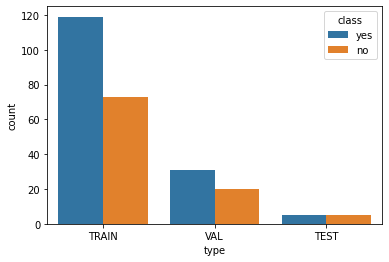

In [127]:
sns.countplot(x='type', hue='class', data=df);

## Data preprocessing

Let's first  crop the image in the following way:

( This idea comes from the following blog: 
https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/ )

In [128]:
IMG_SIZE = (224,224)
!pip install imutils

In [129]:

def show_crop_details(img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(
              img,
              dsize=IMG_SIZE,
              interpolation=cv2.INTER_CUBIC
          )
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  # add contour on the image
  img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

  # add extreme points
  img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
  img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
  img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
  img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

  # crop
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  #plotting
  fig, axes = plt.subplots(1,4, figsize=(15,5))
  titles = [
    'Step 1. Get the original image', 
   'Step 2. Find the biggest contour', 
   'Step 3. Find the extreme points',
   'Step 4. Crop the image'
   ]
  
  images = [img, img_cnt, img_pnt, new_img]

  for i, axes in enumerate(axes.flat):
    axes.imshow(images[i])
    axes.set_axis_off()
    axes.set_title(titles[i])

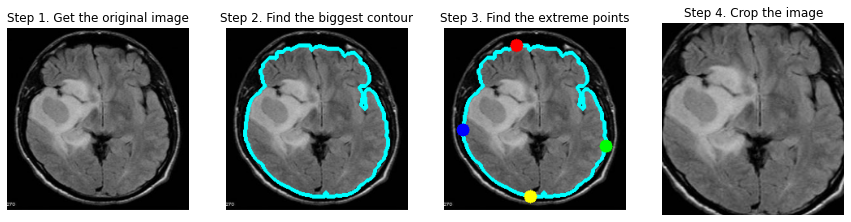

In [130]:
show_crop_details('images/TRAIN/YES/Y256.JPG')

In [131]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [132]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


''

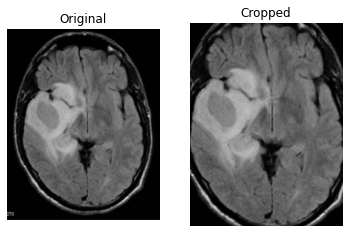

In [133]:
#let's see the difference
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_train[2])
ax[0].set_axis_off()
ax[0].set_title('Original')
ax[1].imshow(X_train_crop[2])
ax[1].set_axis_off()
ax[1].set_title('Cropped')
;

In [134]:
#resizing and preprocessing
def preprocess_imgs(set_name, img_size):
  '''
  resize and preprocess for VGG-16
  '''
  set_new = []
  for img in set_name:
    img = cv2.resize(
        img,
        dsize=img_size,
        interpolation=cv2.INTER_CUBIC
    )
    set_new.append(preprocess_input(img))
  return np.array(set_new)


In [135]:
X_train_final = preprocess_imgs(X_train_crop, img_size=IMG_SIZE)
X_val_final = preprocess_imgs(X_val_crop, img_size=IMG_SIZE)
X_test_final = preprocess_imgs(X_test_crop, img_size=IMG_SIZE)

In [141]:
! mkdir images/TRAIN_PREP images/VAL_PREP images/TEST_PREP images/TRAIN_PREP/YES images/TRAIN_PREP/NO images/VAL_PREP/YES images/VAL_PREP/NO \
images/TEST_PREP/YES images/TEST_PREP/NO

In [137]:
def save_images(X, y, labels, folder_name):
  count = 0
  for i, img in enumerate(X):
    if y[i] == 0:
      cv2.imwrite(folder_name + '/' + 'NO' + '/' + labels[i], img)
    else:
      cv2.imwrite(folder_name + '/' + 'YES' + '/' + labels[i], img)
    count +=1
  print(f'{count} images written in {folder_name}')

In [142]:
#saving preprocessed images
save_images(X_train_final, y_train, train_labels, 'images/TRAIN_PREP')
save_images(X_val_final, y_val, val_labels, 'images/VAL_PREP')
save_images(X_test_final, y_test, test_labels, 'images/TEST_PREP')


192 images written in images/TRAIN_PREP
51 images written in images/VAL_PREP
10 images written in images/TEST_PREP


## The model

### Data augmentation

In [143]:
TRAIN_DIR = 'images/TRAIN_PREP'
VAL_DIR = 'images/VAL_PREP'
RANDOM_SEED = 123


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True, 
    vertical_flip=True,
    #preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_input
)


In [144]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
) 

Found 192 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


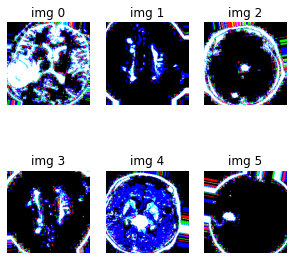

In [145]:
#plot a data aug
x, y = train_generator.next() #1 batch
fig, axes = plt.subplots(2, 3, figsize=(5,5))
for i, axi in enumerate(axes.flat):
  axi.imshow(x[i])
  axi.set_title(f'img {i}')
  axi.set_axis_off()
  ;

### Model Building

In [146]:
#loading base model
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape= IMG_SIZE + (3,)
)

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False 

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [147]:
EPOCHS = 30
es = EarlyStopping(
    monitor='loss',
    patience=6
)

In [148]:
BATCH_SIZE = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    epochs=EPOCHS, 
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
6/6 [==============================] - 128s 22s/step - loss: 5.2614 - accuracy: 0.4932 - val_loss: 1.2479 - val_accuracy: 0.5098
Epoch 2/30
6/6 [==============================] - 85s 14s/step - loss: 4.5949 - accuracy: 0.5027
Epoch 3/30
6/6 [==============================] - 84s 14s/step - loss: 3.5889 - accuracy: 0.5508
Epoch 4/30
6/6 [==============================] - 87s 14s/step - loss: 4.0056 - accuracy: 0.6023
Epoch 5/30
6/6 [==============================] - 86s 14s/step - loss: 4.2501 - accuracy: 0.5339
Epoch 6/30
6/6 [==============================] - 85s 14s/step - loss: 3.6524 - accuracy: 0.5398
Epoch 7/30
6/6 [==============================] - 87s 15s/step - loss: 3.2503 - accuracy: 0.6172
Epoch 8/30
6/6 [==============================] - 92s 15s/step - loss: 2.7221 - accuracy: 0.6392
Epoch 9/30
6/6 [==============================] - 90s 15s/step - loss: 2.7240 - accuracy: 0.6015
Epoch 10/30
6/6 [==============================] - 93s 15s/step - loss: 2.1203 - acc

ValueError: ignored

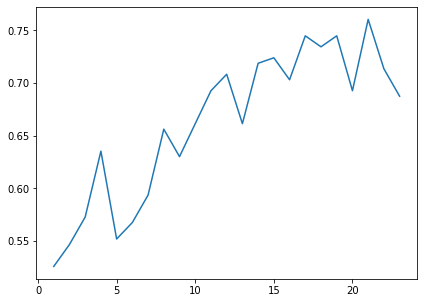

In [150]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [151]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Test Accuracy = 0.5


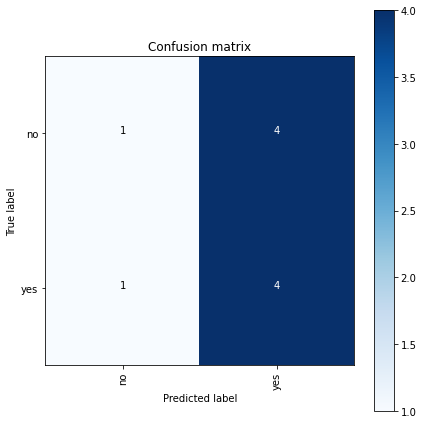

In [152]:
# validate on test set
predictions = model.predict(X_test_final)
predictions = [1 if x >0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print(f'Test Accuracy = {accuracy:.3}')

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes=['no', 'yes'], normalize=False) #list(labels.items())

In [153]:
def predict_img(img):
  img = img.reshape((1, *img.shape))
  return model.predict(img)

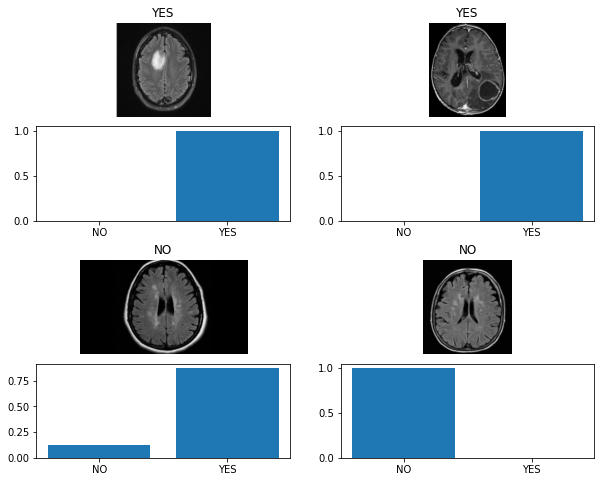

In [154]:
#plot several predictions 
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)
CLASSES = ['NO', 'YES']
for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j == 0:
          ax.imshow(X_test[i])
          ax.set_title(CLASSES[y_test[i]])
          ax.set_axis_off()
        else:
          pred = predict_img(X_test_final[i])
          ax.bar(CLASSES, height=[1-float(pred), float(pred)])
        fig.add_subplot(ax)

fig.show()


## Saliency Map


In [84]:
import tensorflow as tf
import tensorflow.keras as keras

In [155]:
#preprocess image to get it into the right format for the model
def saliency_map(model, original_img, title):
  
  img = keras.preprocessing.image.img_to_array(original_img)
  img = img.reshape((1, *img.shape))
  y_pred = model.predict(img)

  images = tf.Variable(img, dtype=float)

  with tf.GradientTape() as tape:
      pred = model(images, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]    
  grads = tape.gradient(loss, images)
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
  ## normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
  fig, axes = plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(original_img)
  i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
  fig.colorbar(i)
  fig.suptitle(title, fontsize=16)

In [156]:
positives = X_test[y_test== 1]
negatives = X_test[y_test==0]

None
None


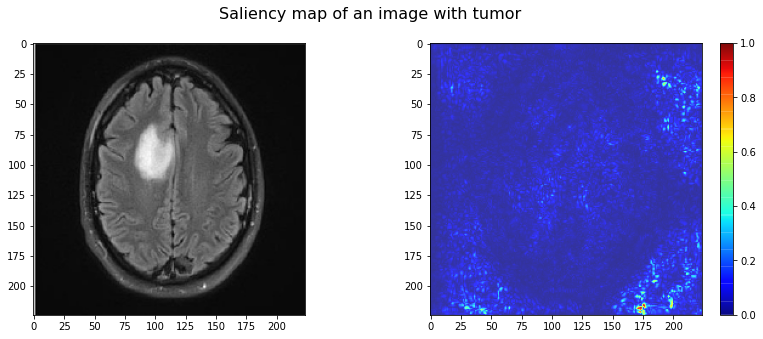

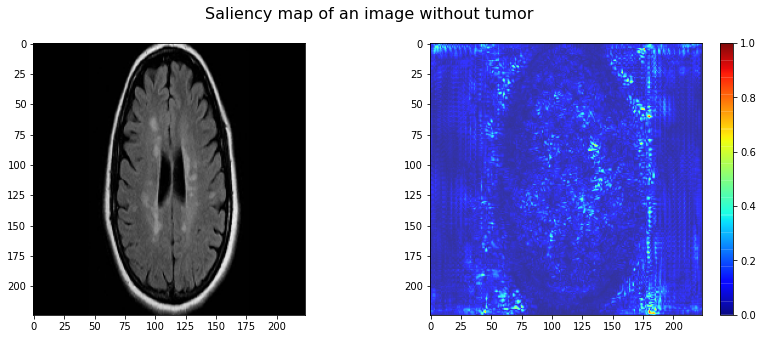

In [158]:
img = cv2.resize(
              positives[0],
              dsize=IMG_SIZE,
              interpolation=cv2.INTER_CUBIC
          )

print(saliency_map(model, img, 'Saliency map of an image with tumor'))

img = cv2.resize(
              negatives[0],
              dsize=IMG_SIZE,
              interpolation=cv2.INTER_CUBIC
          )

print(saliency_map(model, img, 'Saliency map of an image without tumor'))



#Conclusion

We quickly reach around 80% accuracy as expected. We could go further with a segmentation or an object detection model that would localise the tumor.